# Anecdote Detection Machine Learning Model

## Imports

In [100]:
import cPickle
import warnings
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.utils import shuffle


In [101]:
warnings.filterwarnings('ignore') 

## Global Constants
* FNAME_ALL_ANECDOTAL_SENTS
  > File name containing all anecdotal sentences
* FNAME_ALL_NON_ANECDOTAL_SENTS
  > File name containing all non anecdotal sentences
* IMP_COLS
  > List of columns taken into account for prediction of sentences
  * POS
    >> genitive marker
     ' 's
  * NNP
    >>noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...
  * VBD
    >>verb, past tense
    dipped pleaded swiped regummed soaked tidied convened halted registered
    cushioned exacted snubbed strode aimed adopted belied figgered
    speculated wore appreciated contemplated ...
  * VBG
    >>verb, present participle or gerund
    telegraphing stirring focusing angering judging stalling lactating
    hankerin' alleging veering capping approaching traveling besieging
    encrypting interrupting erasing wincing ...
  * PRP
    >>pronoun, personal
    hers herself him himself hisself it itself me myself one oneself ours
    ourselves ownself self she thee theirs them themselves they thou thy us
  * VBZ
    >>verb, present tense, 3rd person singular
    bases reconstructs marks mixes displeases seals carps weaves snatches
    slumps stretches authorizes smolders pictures emerges stockpiles
    seduces fizzes uses bolsters slaps speaks pleads ...
    
    

In [50]:
FNAME_ALL_ANECDOTAL_SENTS = "/home/shirish/BTECHSEM2/project/books/stories/new_complete_stories.txt"
FNAME_ALL_NON_ANECDOTAL_SENTS = "/home/shirish/BTECHSEM2/project/books/annotated_books/stories_without_anecdotes/new_all_stories.txt2"
IMP_COLS = ["POS", "NNP", "VBD", "VBG", "PRP", "VBZ"]


## Functions

In [51]:
def tokenize(fname):
    """
    Parameters:
        fname : string
                It contains the name of the file
    Returns
        value : list of list of tuples of strings
    Description:
        This function reads the file, tokenizes into sentences and then into words.
        Each word is further tagged with the appropriate Parts of Speech Tag using
        nltk.pos_tag. It returns a list of sentences where each sentence is a list
        of tuples containing the word and its corresponding Parts of Speech Tag.
    """
    f = open(fname, "r")
    tagged_sents = []
    s = f.read()
    s = unicode(s, errors="ignore")
    sentences = nltk.sent_tokenize(s)
    for i in sentences:
        tagged_sents.append(nltk.pos_tag(nltk.word_tokenize(i)))
    return tagged_sents

In [52]:
def feature_set_df(tagged_sents, value, imp_cols):
    """
    Parameters:
        tagged_sents : list of list of tuples of strings
                      It contains the list of tagged sentences,
                      i.e. each sentence's words are POS tagged.
        value       : integer
                      It contains the value of the target column
                      to be inserted into the dataframe
        imp_cols    : list of strings
                      It contains the list of important columns that
                      are included in the dataframe and other columns
                      are ignored.
    
    Returns:
        value       : pandas.DataFrame
                      It is a dataframe containing the columns of
                      imp_cols variable and target column.
    
    Description:
        This function creates a dataframe representing the occurrence of
        the parts of speech in each row where each row of the dataframe
        represents a sentence and the columns are the Parts of Speech columns
        as defined in the @param imp_cols. It also contains a target column which
        has the value of @param value. If @param value is 0 it indicates non-anecdotal
        sentence and if @param value is 1 then it indicates anecdotal sentence.
        The value of the cells in the table represent the occurrence of the corresponding
        parts of speech(column other than target column) in the respective sentence(row).
    """
    sents1 = []
    for i in tagged_sents:
        l = {}
        for j in i:
            if j[1].isalpha():
                # If Noun
                if False and j[1][0] == "NNP":# or j[1] == "PRP":
                    l["NNP"] = 1
                else:
                    l[j[1]] = 1
        sents1.append(l)
    df = pd.DataFrame(sents1)
    df.fillna(0, inplace=True)
    features = df[imp_cols]
    # features = df
    features["target"] = value
    return features

In [53]:
def tag_sentences():
    """
    Parameters:
        None
    Returns:
        value : 2-tuple
                0th index of the tuple represents the list of non-anecdotal POS tagged sentences
                1th index of the tuple represents the list of anecdotal POS tagged sentences
    Description:
        This function returns two tagged sentences list
        ie List of non_anecdotal , list of anecdotal sentences
    """
    global FNAME_ALL_ANECDOTAL_SENTS, FNAME_ALL_NON_ANECDOTAL_SENTS
    tagged_sents_1 = tokenize(FNAME_ALL_ANECDOTAL_SENTS)
    tagged_sents_0 = tokenize(FNAME_ALL_NON_ANECDOTAL_SENTS)
    return tagged_sents_0, tagged_sents_1

In [102]:
def create_feature_set_df(tagged_sents_0, tagged_sents_1):
    """
    Parameters:
        tagged_sents_0 = list of list of tuples of strings
                         List of POS tagged non-anecdotal sentences
        tagged_sents_1 = list of list of tuples of strings
                         List of POS tagged anecdotal sentences
    Returns:
        value : pandas.DataFrame
    Description:
        It returns a pandas.DataFrame containing the important POS columns and the target column,
        where 1 indicates the presence of respective POS tag(column) in the sentence,
        and 0 indicates the absence of the respective POS tag(column) in the sentence.
        The target column is 1 if the sentence is anecdotal and 0 if the sentence is
        non anecdotal
    """
    global IMP_COLS
    feature_set_0 = feature_set_df(tagged_sents_0, 0, IMP_COLS) # 0 as the target for non anecdotal sentences
    if(tagged_sents_1 is not None):
        feature_set_1 = feature_set_df(tagged_sents_1, 1, IMP_COLS) # 1 as the target for anecdotal sentences
        feature_set = pd.concat([feature_set_1, feature_set_0])
    else:
        feature_set = feature_set_0
    return feature_set
    


In [55]:
def return_voting_classifier_model(wt):
    """
    Parameters:
        wt    : list of integers
                It contains the list of weights to be assigned
                to the individual classifiers in the voting classifer model
    Returns:
        value : VotingClassifier Object
                It is the voting classifier machine learning model
    Description:
        This function takes as input the weights for the individual classifiers
        being used to create an ensemble machine learning model called Voting
        Classifer.
    """
    return VotingClassifier(estimators=[('SVM', SVC(kernel='rbf')),
                                        ('XGB', xgb.XGBClassifier()),
                                        ('LG', LogisticRegression()),
                                        ('ExtraT', ExtraTreesClassifier(
                                            n_estimators=100)),
                                        ('RF', RandomForestClassifier(
                                            n_estimators=100)),
                                        ('Ada', AdaBoostClassifier(
                                            n_estimators=100)),
                                        ('NB', MultinomialNB())
                                        ], weights=wt)


In [85]:
def eval_model(model, X_train, y_train, X_test, y_test):
    """
    Parameters
        model   : Object
                  It is the machine learning model
        X_train : pd.Dataframe
                  It is the training set for the model
        y_train : pd.Series
                  It contains the target column for the training set
        X_test  : pd.Dataframe
                  It is the testing set for the model
        y_test  : pd.Series
                  It contains the target column for the testing set
    Returns:
        value   : 3-tuple
                  0th index of the tuple contains the accuracy of the model
                  1th index of the tuple contains the predictions of the model
                  for the testing set
                  2th index of the tuple contains the actual model
    Description:
        This function trains the model with the training set and evaluates the model
        on the testing set. It returns the accuracy of the model as well as the
        predictions of the model for the testing set
    """
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    return accuracy_score(predicted, y_test), predicted, model

## Visualization

In [80]:
def plot_confusion_matrix(name, matrix):
    """
    Call this function after calling confusion_matrix_1()
    """  
    arr = list(matrix[0])
    arr.extend(list(matrix[1]))
    labels=['Actual: True, Predicted: True', 'Actual: False, Predicted: True', 'Actual: True, Predicted: False', 'Actual: False, Predicted: False']
    colors=['g','r','r','g']
    for i in range(4):
        plt.bar(i, arr[i], label=labels[i], color=colors[i])
    plt.legend()
    plt.ylabel("Test Sets")
    plt.xticks([i for i in range(4)], ["True Positives", "False Positives", "False Negatives", "True Negatives"])
    plt.title(name)
    plt.savefig(name)
    plt.show()

In [97]:
def plot_heat_map_of_correlation():
    """
    Call this function after calling create_feature_set_df()
    """
    corrmat = df.corr()
    sns.heatmap(corrmat, cbar=True, annot=True)
    plt.savefig("Correlation_Matrix")
    

## Running the script

In [57]:
# TSO = List of POS Tagged non anecdotal sentences
# TS1 = List of POS Tagged anecdotal sentences
TS0, TS1 = tag_sentences()
df = create_feature_set_df(TS0, TS1) # df is the dataframe


In [58]:
TS0[0]

[(u'Whats', 'NNS'),
 (u'in', 'IN'),
 (u'it', 'PRP'),
 (u'for', 'IN'),
 (u'me', 'PRP'),
 (u'?', '.')]

In [59]:
# Print few rows in the dataframe
df.head()

,POS,NNP,VBD,VBG,PRP,VBZ,target
0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,1.0,1.0,0.0,1
3,1.0,1.0,1.0,0.0,1.0,0.0,1
4,0.0,0.0,1.0,1.0,1.0,0.0,1


In [60]:
# Prints number of Anecdotal and Non-anecdotal sentences
a = df.target.value_counts()
try:
    print "Anecdotal sentences = ",
    print a[1]
except KeyError:
    print 0
try:
    print "Non-anecdotal sentences",
    print a[0]
except KeyError:
    print 0

Anecdotal sentences =  603
Non-anecdotal sentences 825


In [87]:
# Shuffle Dataframe
df = shuffle(df)


## Correlation Matrix

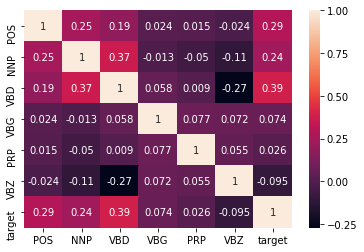

In [98]:
plot_heat_map_of_correlation()

## Evaluation of model

0.7361111111111112
0.75
0.8194444444444444
Accuracy of SVM:  0.8194444444444444
Precision of SVM:  0.6774193548387096
Recall of SVM:  0.875
F1-score of SVM:  0.7636363636363636
SVM Confusion Matrix:  [[38 10]
 [ 3 21]]


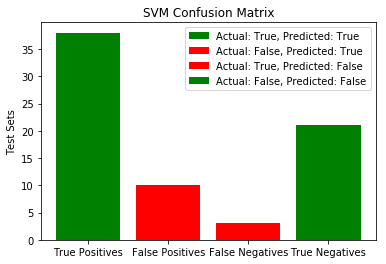

Accuracy of XGB:  0.8194444444444444
Precision of XGB:  0.6774193548387096
Recall of XGB:  0.875
F1-score of XGB:  0.7636363636363636
XGB Confusion Matrix:  [[38 10]
 [ 3 21]]


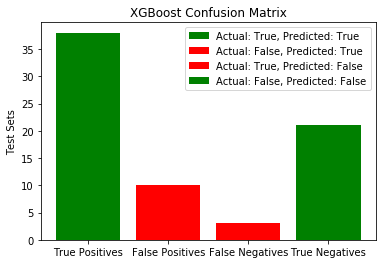

Accuracy of LG:  0.8194444444444444
Precision of LG:  0.6774193548387096
Recall of LG:  0.875
F1-score of LG:  0.7636363636363636
LG Confusion Matrix:  [[38 10]
 [ 3 21]]


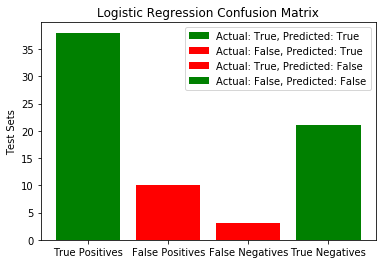

Accuracy of ExtraT:  0.8194444444444444
Precision of ExtraT:  0.6774193548387096
Recall of ExtraT:  0.875
F1-score of ExtraT:  0.7636363636363636
ExtraT Confusion Matrix:  [[38 10]
 [ 3 21]]


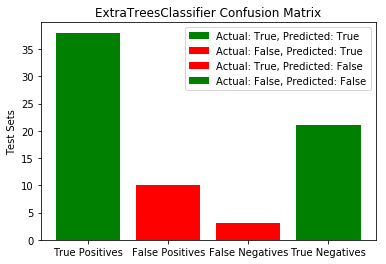

Accuracy of RandomF:  0.8194444444444444
Precision of RandomF:  0.6774193548387096
Recall of RandomF:  0.875
F1-score of RandomF:  0.7636363636363636
RandomF Confusion Matrix:  [[38 10]
 [ 3 21]]


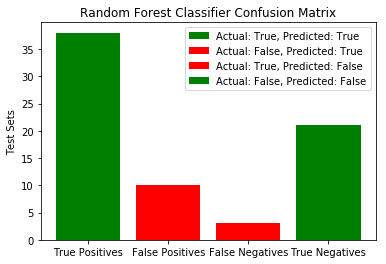

Accuracy of ADA:  0.8194444444444444
Precision of ADA:  0.6774193548387096
Recall of ADA:  0.875
F1-score of ADA:  0.7636363636363636
ADA Confusion Matrix:  [[38 10]
 [ 3 21]]


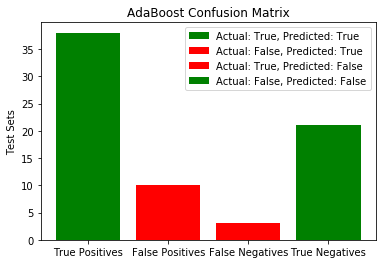

Accuracy of NB:  0.8055555555555556
Precision of NB:  0.6451612903225806
Recall of NB:  0.8695652173913043
F1-score of NB:  0.7407407407407407
NB Confusion Matrix:  [[38 11]
 [ 3 20]]


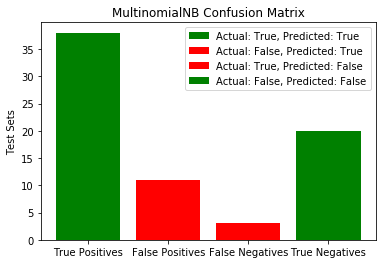

Accuracy of VC:  0.8194444444444444
Precision of VC:  0.6774193548387096
Recall of VC:  0.875
F1-score of VC:  0.7636363636363636
VC Confusion Matrix:  [[38 10]
 [ 3 21]]


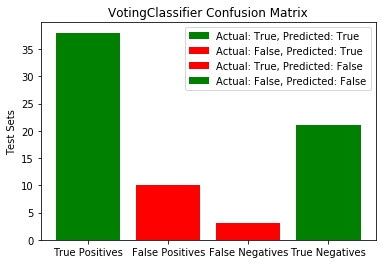

In [94]:
while True:
    df = shuffle(df)
    # Split dataframe in 90-10 train-test ratio
    X_train, X_test, y_train, y_test = train_test_split(df[IMP_COLS], df["target"], test_size=0.10)
    svcacc, svcpred1, _ = eval_model(SVC(kernel='rbf'), X_train, y_train, X_test, y_test)
    xgbacc, xgbpred1, _ = eval_model(xgb.XGBClassifier(n_estimators=100), X_train, y_train, X_test, y_test)
    lgacc, lgpred1, _ = eval_model(LogisticRegression(),  X_train, y_train, X_test, y_test)
    extacc, extpred1, _ = eval_model(ExtraTreesClassifier(n_estimators=100),  X_train, y_train, X_test, y_test)
    rfacc, rfpred1, _ = eval_model(RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)
    adaacc, adapred1, _ = eval_model(AdaBoostClassifier(n_estimators=100), X_train, y_train, X_test, y_test)
    mnbacc, mnbpred1, _ = eval_model(MultinomialNB(), X_train, y_train, X_test, y_test)
    vcacc, vcpred1, model = eval_model(VotingClassifier(estimators=[('SVM', SVC(kernel='rbf')),
                             ('XGB', xgb.XGBClassifier()),
                             ('LG', LogisticRegression()),
                             ('ExtraT', ExtraTreesClassifier(n_estimators=100)),
                             ('RF', RandomForestClassifier(n_estimators=100)),
                             ('Ada', AdaBoostClassifier(n_estimators=100)),
                             ('NB', MultinomialNB())], weights=[5, 5, 5, 1, 2, 5, 1]), X_train, y_train, X_test, y_test)
    
    print vcacc
    if vcacc > 0.80:
        #print "Accuracy of VC: ", vcacc
        #print "Precision of VC: ", precision_score(vcpred1, y_test)
        #print "Recall of VC: ", recall_score(vcpred1, y_test)
        #print "F1-score of VC: ", f1_score(vcpred1, y_test)
        print "Accuracy of SVM: ", svcacc
        print "Precision of SVM: ", precision_score(svcpred1, y_test)
        print "Recall of SVM: ", recall_score(svcpred1, y_test)
        print "F1-score of SVM: ", f1_score(svcpred1, y_test)
        print "SVM Confusion Matrix: ", confusion_matrix(svcpred1, y_test)
        plot_confusion_matrix("SVM Confusion Matrix", confusion_matrix(svcpred1, y_test))
        print "Accuracy of XGB: ", xgbacc
        print "Precision of XGB: ", precision_score(xgbpred1, y_test)
        print "Recall of XGB: ", recall_score(xgbpred1, y_test)
        print "F1-score of XGB: ", f1_score(xgbpred1, y_test)
        print "XGB Confusion Matrix: ", confusion_matrix(xgbpred1, y_test)
        plot_confusion_matrix("XGBoost Confusion Matrix", confusion_matrix(xgbpred1, y_test))

        print "Accuracy of LG: ", lgacc
        print "Precision of LG: ", precision_score(lgpred1, y_test)
        print "Recall of LG: ", recall_score(lgpred1, y_test)
        print "F1-score of LG: ", f1_score(lgpred1, y_test)
        print "LG Confusion Matrix: ", confusion_matrix(lgpred1, y_test)
        plot_confusion_matrix("Logistic Regression Confusion Matrix", confusion_matrix(lgpred1, y_test))

        print "Accuracy of ExtraT: ", extacc
        print "Precision of ExtraT: ", precision_score(extpred1, y_test)
        print "Recall of ExtraT: ", recall_score(extpred1, y_test)
        print "F1-score of ExtraT: ", f1_score(extpred1, y_test)
        print "ExtraT Confusion Matrix: ", confusion_matrix(extpred1, y_test)
        plot_confusion_matrix("ExtraTreesClassifier Confusion Matrix", confusion_matrix(extpred1, y_test))

        print "Accuracy of RandomF: ", rfacc
        print "Precision of RandomF: ", precision_score(rfpred1, y_test)
        print "Recall of RandomF: ", recall_score(rfpred1, y_test)
        print "F1-score of RandomF: ", f1_score(rfpred1, y_test)
        print "RandomF Confusion Matrix: ", confusion_matrix(rfpred1, y_test)
        plot_confusion_matrix("Random Forest Classifier Confusion Matrix", confusion_matrix(rfpred1, y_test))
        print "Accuracy of ADA: ", adaacc
        print "Precision of ADA: ", precision_score(adapred1, y_test)
        print "Recall of ADA: ", recall_score(adapred1, y_test)
        print "F1-score of ADA: ", f1_score(adapred1, y_test)
        print "ADA Confusion Matrix: ", confusion_matrix(adapred1, y_test)
        plot_confusion_matrix("AdaBoost Confusion Matrix", confusion_matrix(adapred1, y_test))
        print "Accuracy of NB: ", mnbacc
        print "Precision of NB: ", precision_score(mnbpred1, y_test)
        print "Recall of NB: ", recall_score(mnbpred1, y_test)
        print "F1-score of NB: ", f1_score(mnbpred1, y_test)
        print "NB Confusion Matrix: ", confusion_matrix(mnbpred1, y_test)
        plot_confusion_matrix("MultinomialNB Confusion Matrix", confusion_matrix(mnbpred1, y_test))
        print "Accuracy of VC: ", vcacc
        print "Precision of VC: ", precision_score(vcpred1, y_test)
        print "Recall of VC: ", recall_score(vcpred1, y_test)
        print "F1-score of VC: ", f1_score(vcpred1, y_test)
        print "VC Confusion Matrix: ", confusion_matrix(vcpred1, y_test)
        plot_confusion_matrix("VotingClassifier Confusion Matrix", confusion_matrix(vcpred1, y_test))
        cPickle.dump(model, open('model.pkl', 'wb'), -1)
        break
